In [12]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")
import glob

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [3]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

### Import model results

In [152]:
model_output_dir = os.path.abspath('../output')

all_files = glob.glob(model_output_dir + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_model = pd.concat(li, axis=0, ignore_index=True).sort_values(['iteration','chainNum','alpha','beta','trialNum'])

# swap mislabeled columns
intendedSequence = df_model['speakerUtterance'].copy()
speakerUtterance = df_model['intendedSequence'].copy()
df_model['speakerUtterance'] = speakerUtterance
df_model['intendedSequence'] = intendedSequence

- iterationName: 0 to 99
- chainNum: index for parameter pair
- alpha: 
- beta: 

In [153]:
def get_intended_refs(intendedSequenceList):
    return[exp for exp in intendedSequenceList if ((not exp.startswith('r_')) & ( not exp.startswith('l_')))]

In [154]:
# preprocessing

df_model['intendedSequenceList'] = df_model['intendedSequence'].apply(lambda string: string.split(' '))
df_model['speakerUtteranceList'] = df_model['speakerUtterance'].apply(lambda string: string.split('~~~'))
df_model['speakerUtteranceWords'] = df_model['speakerUtterance'].apply(lambda string: string.split('~~~'))
df_model['intended_refs'] = df_model['intendedSequenceList'].apply(get_intended_ref_exps)

#checks
assert np.all(df_model['intendedSequenceList'].apply(len) == df_model['descriptionLength'])
assert np.all(df_model['speakerUtteranceList'].apply(len) == df_model['descriptionLength'])

In [ ]:
df_model['repetition'] = np.floor((df_model['trialNum']/3))+1

In [155]:
intended_abstraction_levels = {
    'v': 'block',
    'h': 'block',
    'chunk_L': 'tower',
    'chunk_Pi': 'tower',
    'chunk_C': 'tower',
    'chunk_8': 'subtower',
    'chunk_9': 'subtower'
}

In [156]:
def abstraction_level(intended_ref):
    assert intended_ref in intended_abstraction_levels.keys()
    if intended_ref in intended_abstraction_levels.keys():
        return intended_abstraction_levels[intended_ref]
    else:
        print(intended_ref)
        return ''

In [157]:
df_model['intended_abstraction_level'] = \
        df_model['intended_refs'].apply(lambda intended_refs: [abstraction_level(ref) for ref in intended_refs])

In [158]:
df_model['intended_blocks'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['block'])
df_model['intended_subtowers'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['subtower'])
df_model['intended_towers'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['tower'])

## Referring expressions

<Figure size 864x576 with 0 Axes>

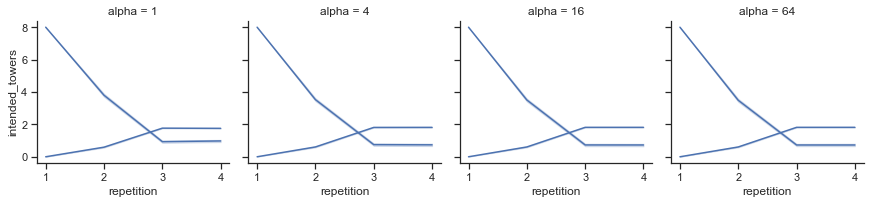

In [172]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='alpha', col_wrap=8)
g.map(sns.lineplot, 'repetition', 'intended_blocks')
# g.map(sns.lineplot, 'trialNum', 'intended_subtowers')
g.map(sns.lineplot, 'repetition', 'intended_towers')

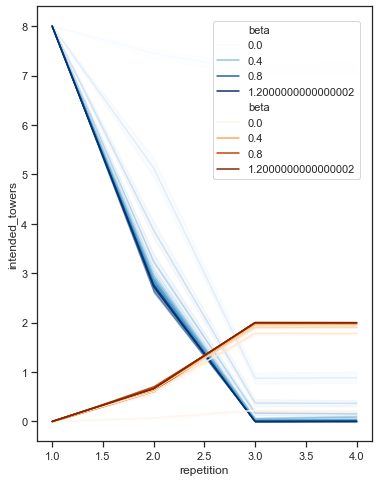

In [187]:
fig = plt.figure(figsize=(6,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.lineplot(data=df_model, x='repetition', y='intended_blocks', hue='beta', palette='Blues')
sns.lineplot(data=df_model, x='repetition', y='intended_towers', hue='beta', palette='Oranges')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='upper right')
plt.xticks = ['1','2','3','4']

## Accuracy

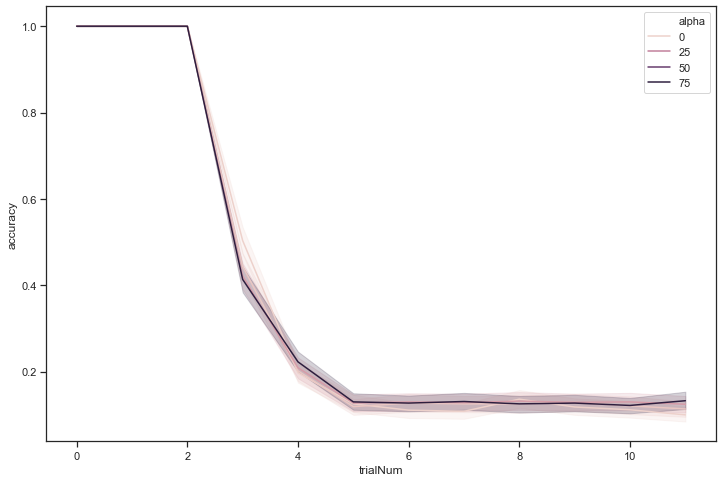

In [78]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.lineplot(data=df_model, y='accuracy', x='trialNum', hue='alpha')

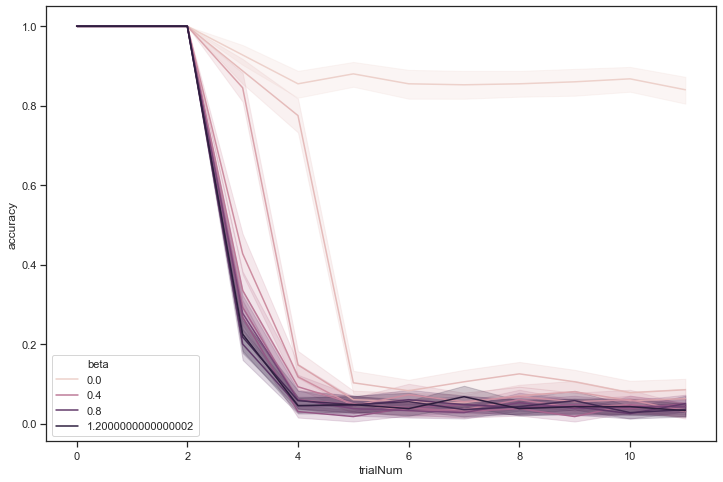

In [79]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.lineplot(data=df_model, y='accuracy', x='trialNum', hue='beta')

<Figure size 1440x576 with 0 Axes>

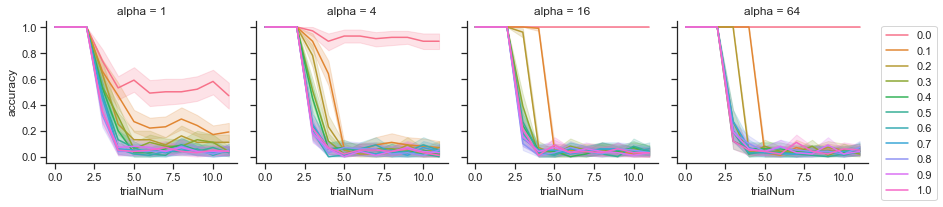

In [97]:
fig = plt.figure(figsize=(20,8))
sns.set_context('poster')
sns.set_style('whitegrid')
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='alpha', col_wrap=8, hue='beta')
g.map(sns.lineplot, 'trialNum', 'accuracy')
plt.legend(bbox_to_anchor=(1.04, 1))


<Figure size 864x720 with 0 Axes>

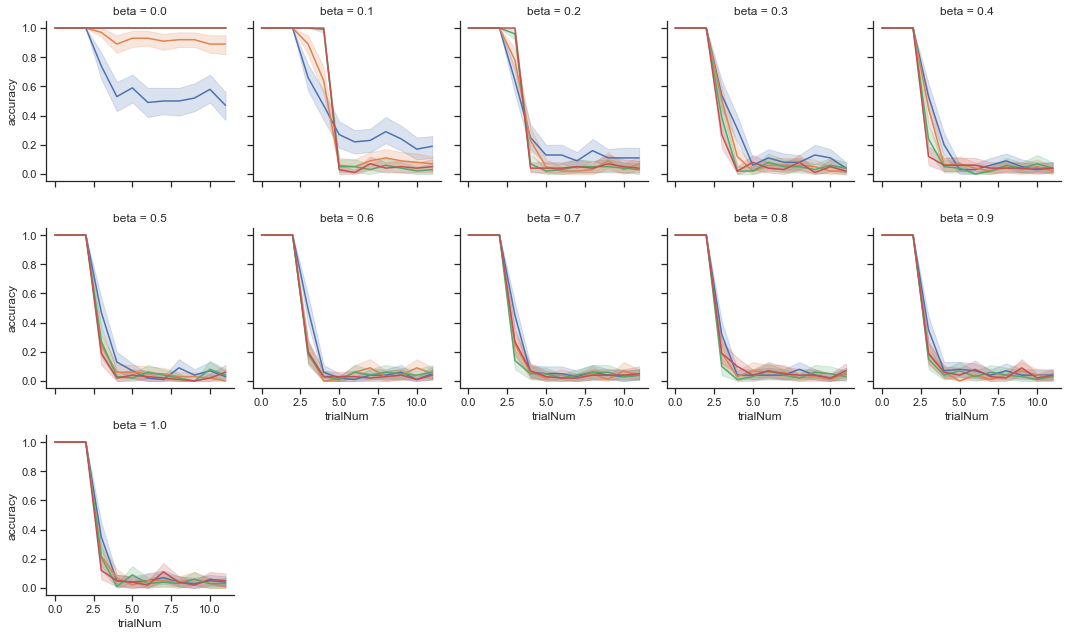

In [88]:
fig = plt.figure(figsize=(12,10))
sns.set_context('poster')
sns.set_style('whitegrid')
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='beta', col_wrap=5, hue='alpha')
g.map(sns.lineplot, 'trialNum', 'accuracy')

## Number of instructions

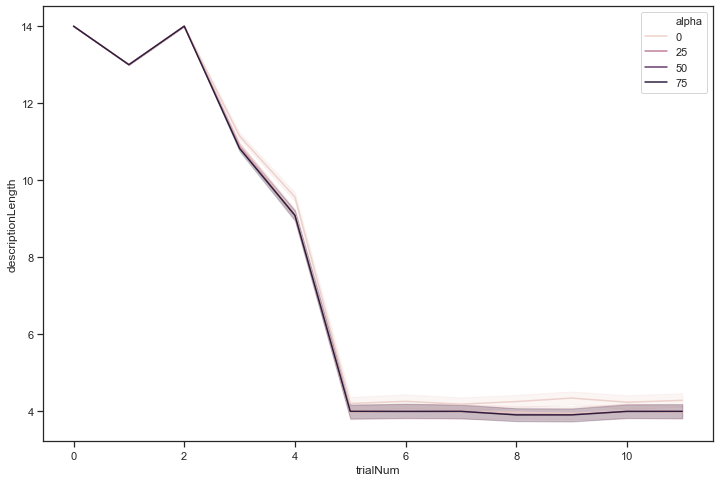

In [90]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.lineplot(data=df_model, y='descriptionLength', x='trialNum', hue='alpha')

<Figure size 1440x576 with 0 Axes>

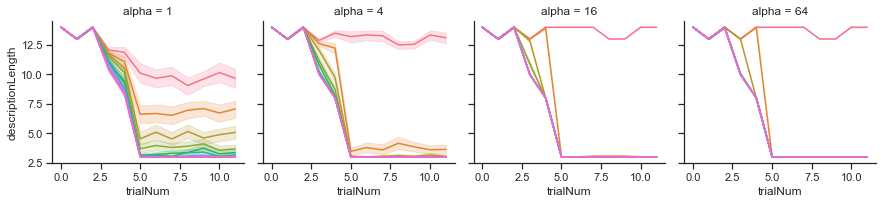

In [92]:
fig = plt.figure(figsize=(20,8))
sns.set_context('poster')
sns.set_style('whitegrid')
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='alpha', col_wrap=8, hue='beta')
g.map(sns.lineplot, 'trialNum', 'descriptionLength')